In [6]:
from keras import layers, models, optimizers
from keras import datasets
from keras import backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
    
K.set_image_data_format('channels_first')
print(K.image_data_format())

Python version :  3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
TensorFlow version :  1.14.0
Keras version :  2.0.0
channels_first


In [7]:
class GAN(models.Sequential):
    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim

        self.generator = self.make_G()
        self.discriminator = self.make_D()

        self.add(self.generator)
        self.discriminator.trainable = False
        self.add(self.discriminator)

        self.compile_all()

    def make_G(self):
        input_dim = self.input_dim

        model = models.Sequential()
        model.add(layers.Dense(1024, activation='tanh', input_dim=input_dim))
        model.add(layers.Dense(128 * 7 * 7, activation='tanh'))
        model.add(layers.BatchNormalization())
        model.add(layers.Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh'))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(1, (5, 5), padding='same', activation='tanh'))
        return model

    def make_D(self):
        model = models.Sequential()
        model.add(layers.Conv2D(64, (5, 5), padding='same', activation='tanh',
                               input_shape=(1, 28, 28)))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Conv2D(128, (5, 5), padding='same', activation='tanh'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(1024, activation='tanh'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def compile_all(self):
        opt_D = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)
        opt_G = optimizers.SGD(lr=0.0005, momentum=0.9, nesterov=True)

        self.compile(loss='binary_crossentropy', optimizer=opt_G)

        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt_D)

    def get_z(self, ln):
        return np.random.uniform(-1.0, 1.0, (ln, self.input_dim))
    
    def train_once(self, x):
        ln = x.shape[0]

        z = self.get_z(ln)
        gen = self.generator.predict(z, verbose=0)
        input_D = np.concatenate((x, gen))
        y_D = [1] * ln + [0] * ln
        loss_D = self.discriminator.train_on_batch(input_D, y_D)

        z = self.get_z(ln)
        self.discriminator.trainable = False
        loss_G = self.train_on_batch(z, [1] * ln)
        self.discriminator.trainable = True

        return loss_D, loss_G

In [8]:
def get_x(x_train, index, batch_size):
        return x_train[index * batch_size:(index + 1) * batch_size]

In [9]:
class MnistData():
    def __init__(self):
        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

        img_rows, img_cols = x_train.shape[1:]

        x_train = x_train.astype('float32') - 127.5
        x_test = x_test.astype('float32') - 127.5
        x_train /= 127.5
        x_test /= 127.5
        
        self.num_classes = 10
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

In [10]:
def main():
    batch_size = 100
    epochs = 50
    input_dim = 100
    sample_size = 6

    data = MnistData()
    x_train = data.x_train
    x_train = x_train.reshape((x_train.shape[0], 1) + x_train.shape[1:])

    gan = GAN(input_dim)

    for epoch in range(epochs):
        print("Epoch", epoch)
    
        for index in range(int(x_train.shape[0] / batch_size)):
            x = get_x(x_train, index, batch_size)
            loss_D, loss_G = gan.train_once(x)

        print('Loss D:', loss_D)
        print('Loss G:', loss_G)

        if epoch % 2 == 0 or epoch == epochs - 1:
            z = gan.get_z(sample_size)
            gen = gan.generator.predict(z, verbose=0)

            plt.figure(figsize=(20, 2))

            for i in range(sample_size):
                ax = plt.subplot(1, sample_size, i + 1)
                plt.imshow(gen[i].reshape((28, 28)))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            plt.show()

W0110 01:57:06.153600 20388 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0110 01:57:06.169600 20388 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:349: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0110 01:57:06.173600 20388 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:3147: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0110 01:57:06.339600 20388 deprecation_wrapper.py:119] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:1578: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_ne

Epoch 0


W0110 01:57:07.834600 20388 deprecation.py:506] From C:\Users\soohyun\Anaconda3\envs\jinho\lib\site-packages\keras\backend\tensorflow_backend.py:519: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loss D: 0.7159833
Loss G: 0.89632607


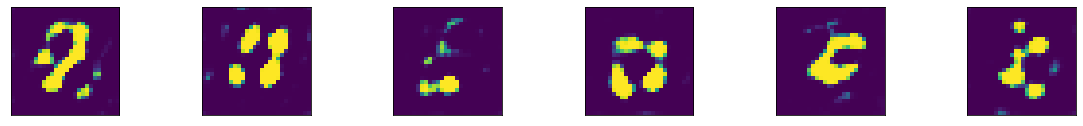

Epoch 1
Loss D: 0.520804
Loss G: 0.9478177
Epoch 2
Loss D: 0.4329651
Loss G: 1.748807


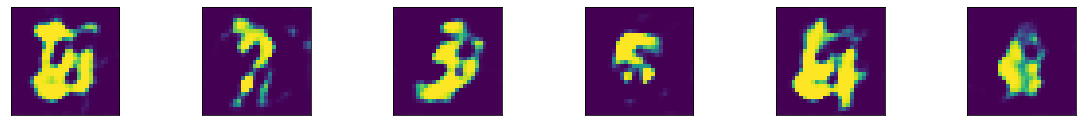

Epoch 3
Loss D: 0.25197965
Loss G: 1.595635
Epoch 4
Loss D: 0.4931184
Loss G: 0.98617005


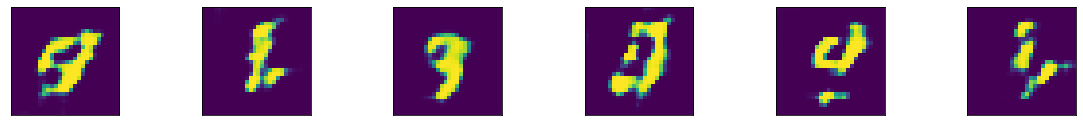

Epoch 5
Loss D: 0.18930435
Loss G: 2.6738644
Epoch 6
Loss D: 0.50236106
Loss G: 1.1798011


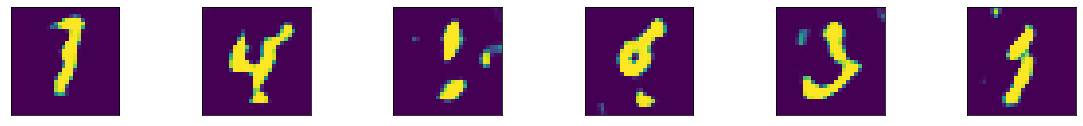

Epoch 7
Loss D: 0.4133772
Loss G: 1.104172
Epoch 8
Loss D: 0.4091384
Loss G: 1.5132217


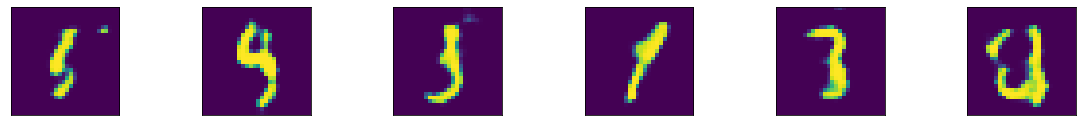

Epoch 9
Loss D: 0.38794377
Loss G: 1.8418425
Epoch 10
Loss D: 0.5381989
Loss G: 0.7296442


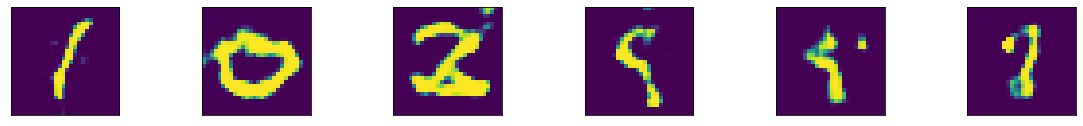

Epoch 11
Loss D: 0.43264323
Loss G: 1.5366632
Epoch 12
Loss D: 0.39605537
Loss G: 1.8293407


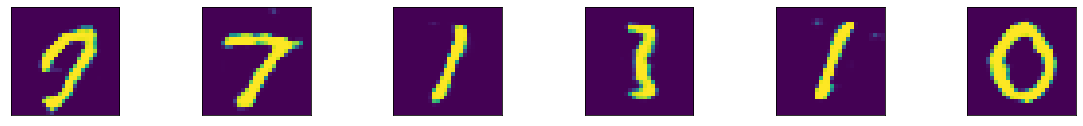

Epoch 13
Loss D: 0.40741935
Loss G: 1.307777
Epoch 14
Loss D: 0.41916984
Loss G: 1.834978


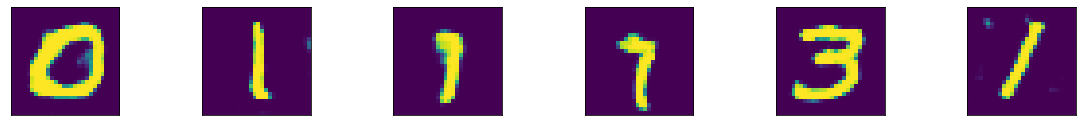

Epoch 15
Loss D: 0.31019676
Loss G: 2.1074975
Epoch 16
Loss D: 0.2745294
Loss G: 2.6321244


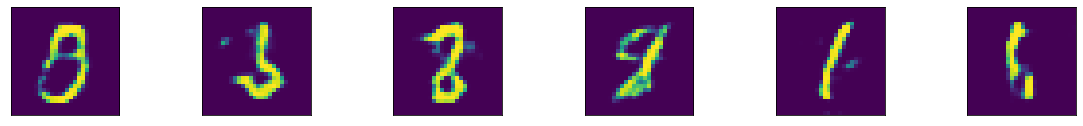

Epoch 17
Loss D: 0.26741222
Loss G: 2.4337957
Epoch 18
Loss D: 0.2890757
Loss G: 2.4167974


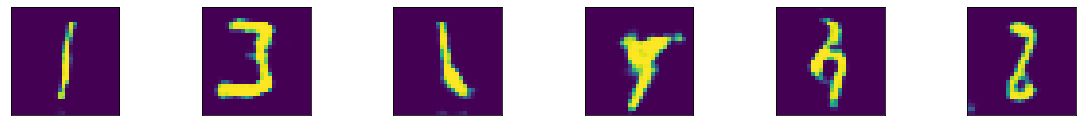

Epoch 19
Loss D: 0.34611052
Loss G: 1.5136154
Epoch 20
Loss D: 0.30352795
Loss G: 1.7129687


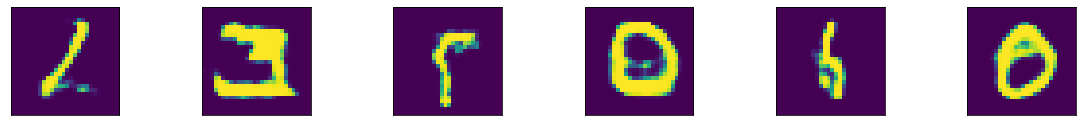

Epoch 21
Loss D: 0.29097766
Loss G: 2.9809675
Epoch 22
Loss D: 0.25858438
Loss G: 2.9323297


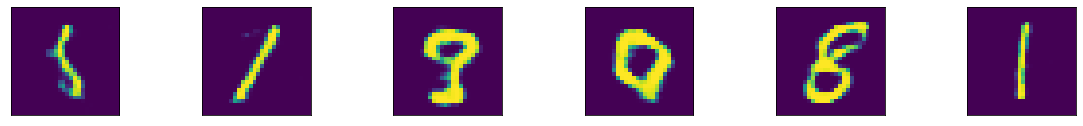

Epoch 23
Loss D: 0.23950966
Loss G: 3.0777512
Epoch 24
Loss D: 0.24558066
Loss G: 2.9553528


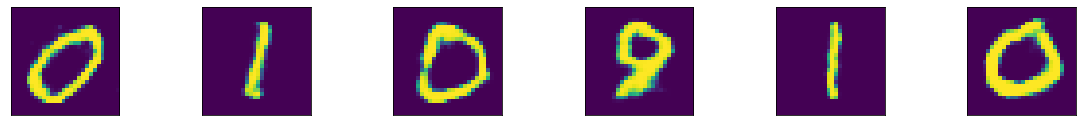

Epoch 25
Loss D: 0.3116256
Loss G: 1.6803882
Epoch 26
Loss D: 0.26512372
Loss G: 3.5196579


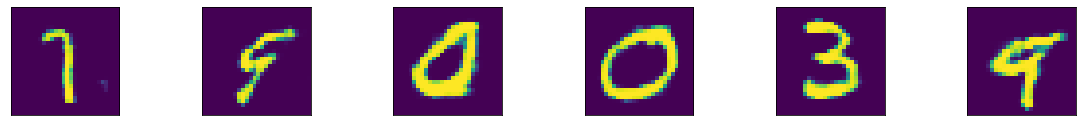

Epoch 27
Loss D: 0.20607235
Loss G: 2.6520684
Epoch 28
Loss D: 0.21843943
Loss G: 2.259625


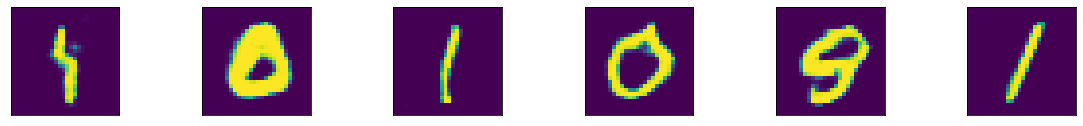

Epoch 29
Loss D: 0.27497226
Loss G: 3.449093
Epoch 30
Loss D: 0.24403597
Loss G: 2.5165532


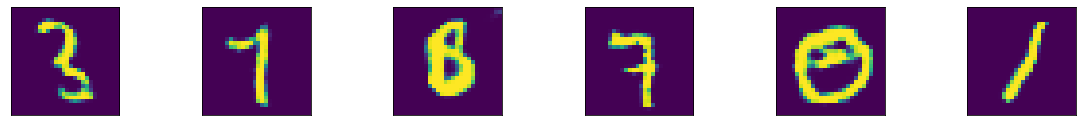

Epoch 31
Loss D: 0.21130966
Loss G: 2.8313935
Epoch 32
Loss D: 0.19089603
Loss G: 2.2555497


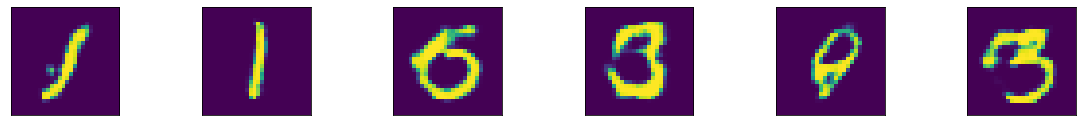

Epoch 33
Loss D: 0.25424686
Loss G: 2.565072
Epoch 34
Loss D: 0.24311438
Loss G: 2.5475047


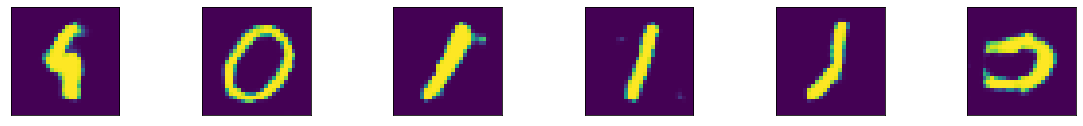

Epoch 35
Loss D: 0.27595073
Loss G: 1.9796782
Epoch 36
Loss D: 0.3183718
Loss G: 2.0249422


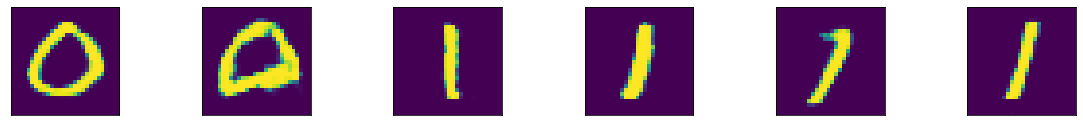

Epoch 37
Loss D: 0.27519205
Loss G: 2.3657458
Epoch 38
Loss D: 0.2627397
Loss G: 2.0357025


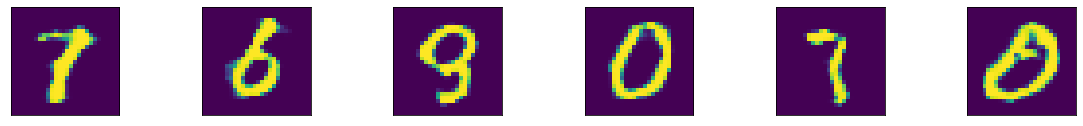

Epoch 39
Loss D: 0.23832558
Loss G: 2.280655
Epoch 40
Loss D: 0.24262284
Loss G: 2.0605094


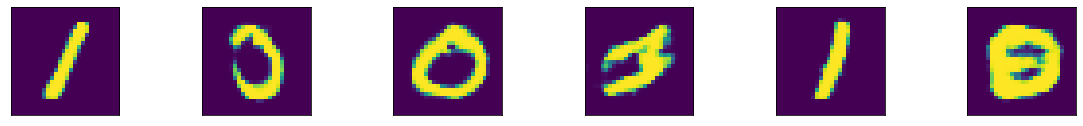

Epoch 41
Loss D: 0.24112843
Loss G: 2.342133
Epoch 42
Loss D: 0.21187821
Loss G: 2.6094167


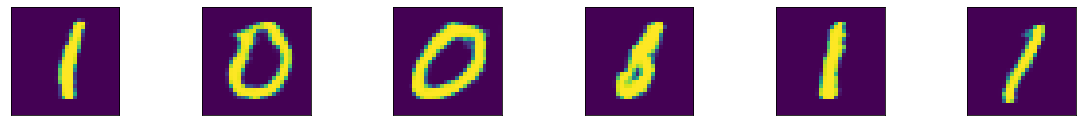

Epoch 43
Loss D: 0.19969589
Loss G: 2.5310786
Epoch 44
Loss D: 0.23304094
Loss G: 2.3696158


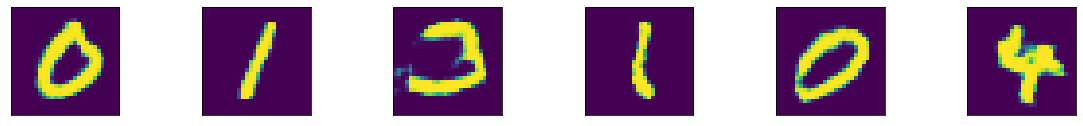

Epoch 45
Loss D: 0.25059825
Loss G: 2.5470245
Epoch 46
Loss D: 0.22550923
Loss G: 2.7645948


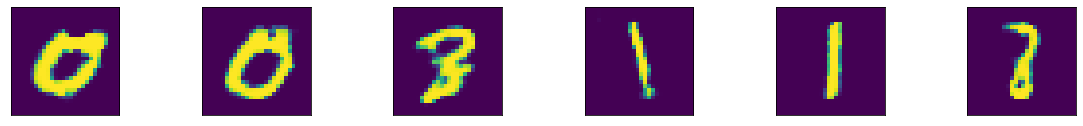

Epoch 47
Loss D: 0.2013504
Loss G: 2.4186547
Epoch 48
Loss D: 0.19381706
Loss G: 2.681434


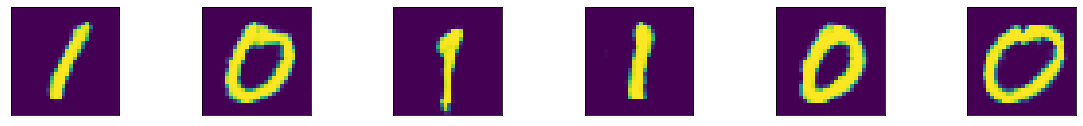

Epoch 49
Loss D: 0.30253407
Loss G: 3.1391735


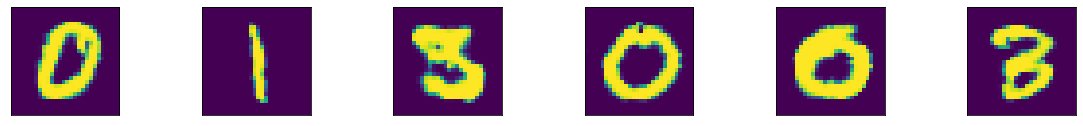

In [11]:
if __name__ == '__main__':
    main()